In [1]:
import os 
import glob
import random
import numpy as np 
import pandas as pd 
import SimpleITK as sitk
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
#
from utils import *
from callBack import call
import configTrain
from network import unet3d
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
folder = '/DataProcess/center/allshare/lixin/code/brats2019/MICCAI_BraTS_2019_Data_Training/name_mapping.csv'

In [3]:
df = pd.read_csv(folder)

In [4]:
df.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1


In [5]:
aug_gen = image_gen3d(df) 
valid_x, valid_y = next(image_gen3d(df, 18)) #

In [6]:
x, y = next(aug_gen)

In [7]:
x.shape

(4, 128, 128, 128, 4)

In [8]:
y.shape

(4, 128, 128, 128, 4)

In [9]:
import matplotlib.pyplot as plt

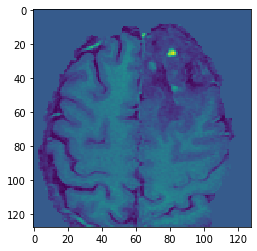

In [10]:
plt.imshow(x[2,100,:,:,3])

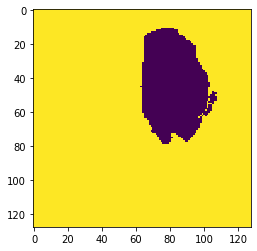

In [11]:
plt.imshow(y[2,100,:,:,0])

In [12]:
np.max(x)

10.955212700708492

In [13]:
model = unet3d((128,128,128,4))

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 1744        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 128 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 128 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv3d_2 (

# Train

In [15]:
callbacks_list = call(
         weight_path = configTrain.best_model_save_path, 
         monitor = configTrain.monitor , 
         mode = configTrain.mode, 
         reduce_lr_p = configTrain.reduce_lr_p, 
         early_p = configTrain.early_p, 
         log_csv_path = configTrain.log_csv_path,
         min_lr = configTrain.min_lr,
         factor = 0.5,
         min_delta = 0.0001,
         cooldown = 2,
         verbose = 1)

/opt/anaconda3/envs/py36_tensorflow-1.12.2/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [16]:
import segmentation_models as sm
# muti_model = multi_gpu_model(net, gpus=3) 
# muti_model.load_weights() 
# muti_model = net
model.compile(
    optimizer=Adam(lr = configTrain.lr),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

loss_history = [model.fit_generator(
                        aug_gen, 
                        steps_per_epoch = 50, 
                        epochs = 10, 
                        validation_data = (valid_x, valid_y),
                        callbacks = callbacks_list,
                        workers = 1 
                                  )]

Segmentation Models: using `keras` framework.
Epoch 1/10
13/50 [======>.......................] - ETA: 5:42 - loss: 1.4598 - iou_score: 0.0887

KeyboardInterrupt: 

In [ ]:
net.save(train_config.model_save_path)

print('Done!')